In [ ]:
#@title Libraries
print("Loading Libraries")

import copy
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import timm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from collections import defaultdict, OrderedDict
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm

print("Libraries Loaded")

Loading Libraries
Libraries Loaded


In [ ]:
# ===== Hyperparameters & Settings =====
train_pct          = 0.8    #@param {type:"number"}
val_pct            = 0.1    #@param {type:"number"}
test_pct           = 0.1    #@param {type:"number"}
seed               = 42     #@param {type:"number"}
var_batch_size     = 32    #@param {type:"number"}
num_epochs         = 50     #@param {type:"number"}
patience           = 10     #@param {type:"number"}
image_width        = 224    #@param {type:"number"}
image_height       = 224    #@param {type:"number"}
var_kernel_size    = 3      #@param {type:"number"}
learning_rate      = 0.005  #@param {type:"number"}

# ===== Dataset / Augmentation Flags ===== (actualizado)
balancear_por_clase = True  #@param {type:"boolean"}
use_flip            = False  #@param {type:"boolean"}
use_rotation        = False  #@param {type:"boolean"}
rotation_degrees    = 20    #@param {type:"number"}

# Nuevas variables para data augmentation
use_color_jitter    = False  #@param {type:"boolean"}
brightness_factor   = 0.2   #@param {type:"number"}
contrast_factor     = 0.3   #@param {type:"number"}
saturation_factor   = 0.1   #@param {type:"number"}
flip_probability    = 0.6   #@param {type:"number"}


In [ ]:
#@title Dataset, Early Stopping & Eye Disease Classifier
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, mode='min', restore_best=True):
        """
        Utility to stop training when a monitored metric stops improving.

        Args:
            patience (int): Number of epochs to wait before stopping.
            min_delta (float): Minimum change to count as improvement.
            mode (str): 'min' for loss, 'max' for accuracy/score.
            restore_best (bool): Restore best weights after stopping.
        """
        assert mode in ('min', 'max')
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.restore_best = restore_best

        self.best_score = None
        self.counter = 0
        self.best_state = None
        self.should_stop = False

    def _is_improvement(self, current, best):
        if self.mode == 'min':
            return (best - current) > self.min_delta
        else:  # 'max'
            return (current - best) > self.min_delta

    def step(self, current_value, model):
        # Initialize best score on first call
        if self.best_score is None:
            self.best_score = current_value
            if self.restore_best:
                self.best_state = copy.deepcopy(model.state_dict())
            self.counter = 0
            return False  # never stops on the first step

        if self._is_improvement(current_value, self.best_score):
            # Metric improved: reset patience and save model state
            self.best_score = current_value
            if self.restore_best:
                self.best_state = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
             # Metric did not improve enough
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        return self.should_stop

    def restore(self, model):
        if self.restore_best and self.best_state is not None:
            model.load_state_dict(self.best_state)

class EyeDiseaseDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

class SimpleEyeDiseaseClassifer(nn.Module):
    def __init__(self, num_classes):
        super(SimpleEyeDiseaseClassifer, self).__init__()
         # Load pretrained EfficientNet-B0 from timm library
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)

        # Toma todas las capas del modelo base excepto la última (la cabeza clasificadora)
        # para usarlas como extractor de características (backbone).
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        # Tamaño del último mapa de características de EfficientNet-B0 (canales).
        enet_out_size = 1280

        # Make a classifier
        self.classifier = nn.Sequential(             # Secuencia de capas para mapear features -> logits de clases.
            nn.Flatten(),                            # Aplana de [N, C, H, W] a [N, C*H*W] (aquí H=W=1 normalmente).
            nn.Linear(enet_out_size, num_classes)    # Linear layer: 1280 -> num_classes
        )

    def forward(self, x):
        x = self.features(x)                         # Salida típica: [N, 1280, 1, 1] en EfficientNet-B0
        output = self.classifier(x)                  # Aplana y proyecta a [N, num_classes].
        return output                                # Devuelve logits (sin softmax); usá CrossEntropyLoss.

In [ ]:
class Rescaling(nn.Module):
    def __init__(self, scale=1/255.0):
        super().__init__()
        self.scale = scale
    def forward(self, x):
        return x * self.scale

class SimpleConvNet(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.features = nn.Sequential(OrderedDict([
            ("slng_1_div_255", Rescaling(1/255.0)),
            ("c_conv_1", nn.Conv2d(3, 64, kernel_size=var_kernel_size, stride=1, padding=1, bias=True)),
            ("p_conv_1", nn.MaxPool2d(kernel_size=var_kernel_size, stride=3, padding=1)),
            ("c_conv_2", nn.Conv2d(64, 32, kernel_size=var_kernel_size, stride=1, padding=1, bias=True)),
            ("p_conv_2", nn.MaxPool2d(kernel_size=var_kernel_size, stride=3, padding=1)),
            ("c_conv_3", nn.Conv2d(32, 16, kernel_size=var_kernel_size, stride=1, padding=1, bias=True)),
            ("p_conv_3", nn.MaxPool2d(kernel_size=var_kernel_size, stride=3, padding=1)),
            ("c_conv_4", nn.Conv2d(16, 8,  kernel_size=var_kernel_size, stride=1, padding=1, bias=True)),
            ("p_conv_4", nn.MaxPool2d(kernel_size=var_kernel_size, stride=3, padding=1)),
        ]))

        self.flat = nn.Flatten()
        self.lineal_1 = nn.Linear(3*3*8, 16, bias=True)  # 72 → 16
        self.output   = nn.Linear(16, num_classes, bias=True)

    def forward(self, x):
        x = self.features(x)      # (N, 8, 3, 3)
        x = self.flat(x)          # (N, 72)
        x = self.lineal_1(x)      # (N, 16)
        x = self.output(x)        # (N, 4)
        return x


In [ ]:
# Download latest dataset version
path = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'eye-diseases-classification' dataset.
Path to dataset files: /kaggle/input/eye-diseases-classification


In [ ]:
# Get the indices of each type"
data_dir = os.path.join(path,'dataset')
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'cataract', 1: 'diabetic_retinopathy', 2: 'glaucoma', 3: 'normal'}


In [ ]:
# --- Dataset setup ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset = ImageFolder(data_dir, transform=transform)

# Build target -> class mapping
target_to_class2 = {v: k for k, v in dataset.class_to_idx.items()}
all_labels = [target_to_class2[i] for i in range(len(target_to_class2))]
print(target_to_class2)

# --- Plot 16 random images ---
fig, m_axs = plt.subplots(4, 4, figsize=(18, 18))

for i, c_ax in enumerate(m_axs.flatten()):
    idx = random.randint(0, len(dataset) - 1)
    c_x, c_y = dataset[idx]

    # Move to CPU and convert [C, H, W] -> [H, W, C]
    c_x_cpu = c_x.cpu().permute(1, 2, 0)

    # Check if image is grayscale repeated in 3 channels
    if c_x_cpu.shape[2] == 3 and torch.allclose(c_x_cpu[:,:,0], c_x_cpu[:,:,1]) and torch.allclose(c_x_cpu[:,:,1], c_x_cpu[:,:,2]):
        img_to_show = c_x_cpu[:,:,0]
        cmap = 'gray'
    else:
        img_to_show = c_x_cpu
        cmap = None

    c_ax.imshow(img_to_show, cmap=cmap)
    c_ax.set_title(target_to_class2[c_y], fontsize=10)
    c_ax.axis('off')

plt.tight_layout(pad=1.0)
plt.show()


Output hidden; open in https://colab.research.google.com to view.

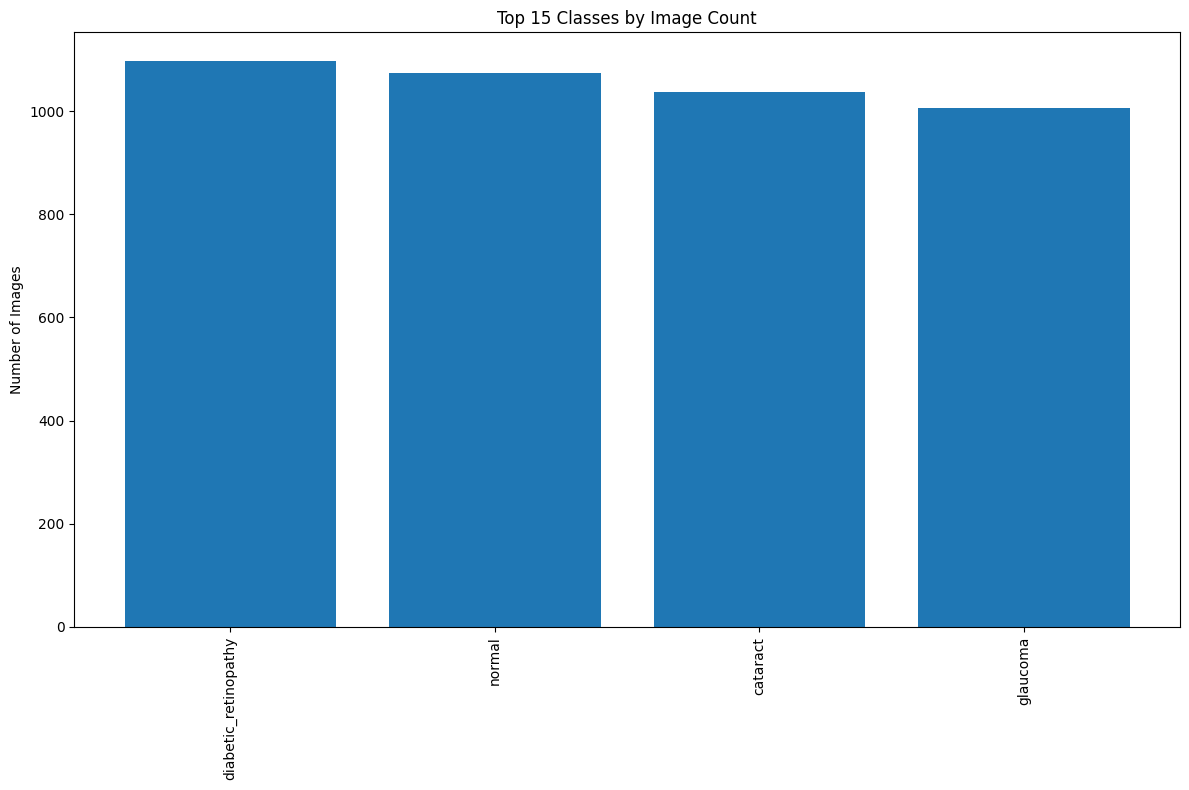

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Get the original dataset without transforms
orig_dataset = ImageFolder(data_dir)  # no transforms

# Use the original dataset to get labels
all_labels = [label for _, label in orig_dataset]  # orig_dataset from ImageFolder
target_to_class = {v: k for k, v in orig_dataset.class_to_idx.items()}  # idx -> class name
all_class_names = [target_to_class[label] for label in all_labels]

# Count occurrences
label_counts = Counter(all_class_names)
top_labels = label_counts.most_common(15)  # top 15

labels, counts = zip(*top_labels)

# --- Plot ---
fig, ax1 = plt.subplots(1,1,figsize=(12, 8))
ax1.bar(np.arange(len(counts))+0.5, counts)
ax1.set_xticks(np.arange(len(counts))+0.5)
ax1.set_xticklabels(labels, rotation=90, fontsize=10)
ax1.set_ylabel("Number of Images")
ax1.set_title("Top 15 Classes by Image Count")
plt.tight_layout()
plt.show()


In [ ]:
# Build transforms dynamically
transform_list = [transforms.Resize((image_width, image_height))]

# Transformaciones geométricas
if use_flip:
    transform_list.append(transforms.RandomHorizontalFlip(p=flip_probability))

if use_rotation:
    transform_list.append(transforms.RandomRotation(rotation_degrees))

# Transformaciones de color
if use_color_jitter:
    color_jitter_params = {}
    if brightness_factor > 0:
        color_jitter_params['brightness'] = brightness_factor
    if contrast_factor > 0:
        color_jitter_params['contrast'] = contrast_factor
    if saturation_factor > 0:
        color_jitter_params['saturation'] = saturation_factor

    if color_jitter_params:  # Solo agregar si hay al menos un parámetro
        transform_list.append(transforms.ColorJitter(**color_jitter_params))

# Conversión final
transform_list.append(transforms.ToTensor())

# Crear el transform compuesto
transform = transforms.Compose(transform_list)

# ===== Información de las transformaciones aplicadas =====
print("=== TRANSFORMACIONES APLICADAS ===")
print(f"✓ Resize: {image_width}x{image_height}")

if use_flip:
    print(f"✓ Random Horizontal Flip: {flip_probability*100}% probabilidad")
else:
    print("✗ Flip: Deshabilitado")

if use_rotation:
    print(f"✓ Random Rotation: ±{rotation_degrees} grados")
else:
    print("✗ Rotation: Deshabilitado")

if use_color_jitter:
    jitter_info = []
    if brightness_factor > 0:
        jitter_info.append(f"brightness=±{brightness_factor}")
    if contrast_factor > 0:
        jitter_info.append(f"contrast=±{contrast_factor}")
    if saturation_factor > 0:
        jitter_info.append(f"saturation=±{saturation_factor}")

    if jitter_info:
        print(f"✓ Color Jitter: {', '.join(jitter_info)}")
    else:
        print("✗ Color Jitter: Sin parámetros configurados")
else:
    print("✗ Color Jitter: Deshabilitado")

print("✓ ToTensor: Siempre aplicado")

full_dataset = EyeDiseaseDataset(data_dir, transform=transform)

=== TRANSFORMACIONES APLICADAS ===
✓ Resize: 224x224
✗ Flip: Deshabilitado
✗ Rotation: Deshabilitado
✗ Color Jitter: Deshabilitado
✓ ToTensor: Siempre aplicado


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import ImageFolder

if use_flip or use_color_jitter or use_rotation:

  # Get the original dataset without transforms
  orig_dataset = ImageFolder(data_dir)  # no transforms

  # --- Plot side-by-side pairs ---
  fig, axes = plt.subplots(2, 6, figsize=(24, 8))  # 2 rows, 6 cols = 3 pairs per row

  for i in range(6):  # 6 pairs total
      # Random index
      idx = random.randint(0, len(full_dataset) - 1)

      # --- Original image ---
      orig_img, orig_label = orig_dataset[idx]
      orig_array = np.array(orig_img)

      # --- Transformed image ---
      c_x, c_y = full_dataset[idx]  # (transformed image, label)
      c_x_cpu = c_x.cpu().permute(1, 2, 0)  # [C, H, W] -> [H, W, C]

      # Handle grayscale repeated in 3 channels
      if c_x_cpu.shape[2] == 3 and np.allclose(c_x_cpu[:,:,0], c_x_cpu[:,:,1]) and np.allclose(c_x_cpu[:,:,1], c_x_cpu[:,:,2]):
          trans_img = c_x_cpu[:,:,0]
          cmap = 'bone'
      else:
          trans_img = c_x_cpu
          cmap = None

      # Determine subplot location
      row_idx = i // 3
      col_start = (i % 3) * 2

      # Display original
      axes[row_idx, col_start].imshow(orig_array, cmap='bone')
      axes[row_idx, col_start].set_title('Original', fontsize=10)
      axes[row_idx, col_start].axis('off')

      # Display transformed
      axes[row_idx, col_start + 1].imshow(trans_img, cmap=cmap)
      axes[row_idx, col_start + 1].set_title('Transformed', fontsize=10)
      axes[row_idx, col_start + 1].axis('off')

  plt.tight_layout(pad=0.2)
  plt.show()
else:
  print("=== SIN TRANSFORMACIONES APLICADAS ===")


=== SIN TRANSFORMACIONES APLICADAS ===


In [ ]:
#model = SimpleEyeDiseaseClassifer(num_classes=len(target_to_class))
#print(str(model)[:500])

In [ ]:
#pool_size=3, use_gap=False,linear_hidden_neurons=16, dropout_p=0.3, act='relu'
model = SimpleConvNet(num_classes=len(target_to_class))

summary(model, input_size=(var_kernel_size, image_width, image_height), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rescaling-1          [-1, 3, 224, 224]               0
            Conv2d-2         [-1, 64, 224, 224]           1,792
         MaxPool2d-3           [-1, 64, 75, 75]               0
            Conv2d-4           [-1, 32, 75, 75]          18,464
         MaxPool2d-5           [-1, 32, 25, 25]               0
            Conv2d-6           [-1, 16, 25, 25]           4,624
         MaxPool2d-7             [-1, 16, 9, 9]               0
            Conv2d-8              [-1, 8, 9, 9]           1,160
         MaxPool2d-9              [-1, 8, 3, 3]               0
          Flatten-10                   [-1, 72]               0
           Linear-11                   [-1, 16]           1,168
           Linear-12                    [-1, 4]              68
Total params: 27,276
Trainable params: 27,276
Non-trainable params: 0
---------------------------------

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
if balancear_por_clase:
    # Paso 1: agrupar índices por clase
    indices_por_clase = defaultdict(list)
    for idx, (_, label) in enumerate(full_dataset):
        indices_por_clase[label].append(idx)

    # Paso 2: determinar cuántos usar por clase (mínimo disponible)
    min_count = min(len(lst) for lst in indices_por_clase.values())
    if min_count == 0:
        print("⚠ No se puede balancear: alguna clase no tiene registros.")
    else:
        print(f"📊 Balanceo activado. Cantidad unificada por clase: {min_count}")

        train_indices, val_indices, test_indices = [], [], []

        generator = torch.Generator().manual_seed(seed)

        for clase, idxs in indices_por_clase.items():
            # Paso 3: tomar muestra aleatoria de tamaño min_count
            idxs = torch.tensor(idxs)
            shuffled = idxs[torch.randperm(len(idxs), generator=generator)[:min_count]]

            n_train = int(min_count * train_pct)
            n_val   = int(min_count * val_pct)
            n_test  = min_count - n_train - n_val  # exact match

            train_indices.extend(shuffled[:n_train].tolist())
            val_indices.extend(shuffled[n_train:n_train+n_val].tolist())
            test_indices.extend(shuffled[n_train+n_val:].tolist())

        # Paso 4: crear datasets balanceados
        train_ds = Subset(full_dataset, train_indices)
        val_ds   = Subset(full_dataset, val_indices)
        test_ds  = Subset(full_dataset, test_indices)

else:
    # Modo normal (sin balanceo por clase)
    n = len(full_dataset)
    n_train = int(n * train_pct)
    n_val   = int(n * val_pct)
    n_test  = n - n_train - n_val  # que cierre exacto
    generator = torch.Generator().manual_seed(seed)
    train_ds, val_ds, test_ds = random_split(full_dataset, [n_train, n_val, n_test], generator=generator)

train_loader = DataLoader(train_ds, batch_size=int(var_batch_size/2), shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=var_batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=var_batch_size, shuffle=False, num_workers=0, pin_memory=True)

#TODO Balancear los registros que se tomand de cada tipo, para que sea parejo. Osea de la primara clase tomar un 80, 10, 10, de la segunda clase igual y asi...
# Creo que está

batch_size = var_batch_size  # para mostrarlo en el mensaje

print(f"📚 Entrenamiento: {len(train_loader.dataset)} muestras "
      f"→ {len(train_loader)} lotes por época (batch size = {int(batch_size/2)})")

print(f"🧪 Validación:    {len(val_loader.dataset)} muestras "
      f"→ {len(val_loader)} lotes por época (batch size = {batch_size})")

print(f"🔎 Prueba:        {len(test_loader.dataset)} muestras "
      f"→ {len(test_loader)} lotes por época (batch size = {batch_size})")


train_losses, val_losses = [], []
train_accs, val_accs     = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Early stopper: para val_loss usamos mode='min'
early_stopper = EarlyStopping(patience=patience, min_delta=0.001, mode='min', restore_best=True)


📊 Balanceo activado. Cantidad unificada por clase: 1007
📚 Entrenamiento: 3220 muestras → 26 lotes por época (batch size = 128)
🧪 Validación:    400 muestras → 4 lotes por época (batch size = 128)
🔎 Prueba:        408 muestras → 4 lotes por época (batch size = 128)


In [ ]:

for epoch in range(num_epochs):
    model.train()
    running_loss  = 0.0
    train_total   = 0
    train_correct = 0
    for images, labels in tqdm(train_loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)
        # reset accumulated gradients in model parameters
        optimizer.zero_grad()
        # forward pass: model predictions for the batch
        outputs = model(images)
        # compute loss comparing predictions vs labels
        loss = criterion(outputs, labels)
        # backpropagation: compute gradients d(loss)/d(param)
        loss.backward()
        # update parameters using the optimizer
        optimizer.step()
        # accumulate loss * batch size (for later averaging)
        running_loss += loss.item() * labels.size(0)

        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
    # promedio de pérdida de train por ejemplo
    train_loss = running_loss / len(train_loader.dataset)

    train_acc = train_correct / train_total if train_total > 0 else 0.0
    # guarda la pérdida de train de esta época
    train_losses.append(train_loss)

    train_accs.append(train_acc)

    # Validation phase
    model.eval()
    running_loss = 0.0
    val_correct  = 0
    val_total    = 0

    # Etiquetas y probabilidades para ROC
    val_true_labels = []
    val_pred_probabilities = []
    with torch.no_grad():  # sin gradientes en validación (ahorra memoria y tiempo)
        for images, labels in tqdm(val_loader, desc='Validation'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
            # forward pass en validación
            outputs = model(images)
            # calcula la pérdida de validación del batch
            loss = criterion(outputs, labels)
            # acumula pérdida ponderada por tamaño de batch
            running_loss += loss.item() * labels.size(0)

            # accuracy validación
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            # probabilidades para ROC (softmax sobre logits)
            probs = torch.softmax(outputs, dim=1)          # (N,C)

            # guardar en listas (mover a CPU)
            val_true_labels.extend(labels.detach().cpu().tolist())
            val_pred_probabilities.extend(probs.detach().cpu().numpy())

    # promedio de pérdida de validación por ejemplo
    val_loss = running_loss / len(val_loader.dataset)

    val_acc = val_correct / val_total if val_total > 0 else 0.0
    # guarda la pérdida de validación de esta época
    val_losses.append(val_loss)

    val_accs.append(val_acc)
    print(
        f"Epoch {epoch+1}/{num_epochs} - "
        f"Tra_Accuracy: {train_acc:.4f} - Tra_Loss: {train_loss:.4f} - "
        f"Val_Accuracy: {val_acc:.4f} - Val_Loss: {val_loss:.4f}"
    )

    # Early stopping check
    if early_stopper.step(val_loss, model):
        print(f"⛔ Early stopping at epoch {epoch+1} (no improvements for {early_stopper.patience} epochs).")
        break

Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/50 - Tra_Accuracy: 0.2432 - Tra_Loss: 1.4028 - Val_Accuracy: 0.2500 - Val_Loss: 1.3941


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/50 - Tra_Accuracy: 0.2500 - Tra_Loss: 1.3932 - Val_Accuracy: 0.2500 - Val_Loss: 1.3898


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/50 - Tra_Accuracy: 0.2463 - Tra_Loss: 1.3897 - Val_Accuracy: 0.2500 - Val_Loss: 1.3878


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/50 - Tra_Accuracy: 0.2460 - Tra_Loss: 1.3869 - Val_Accuracy: 0.2500 - Val_Loss: 1.3851


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/50 - Tra_Accuracy: 0.2873 - Tra_Loss: 1.3767 - Val_Accuracy: 0.3025 - Val_Loss: 1.3433


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/50 - Tra_Accuracy: 0.3885 - Tra_Loss: 1.2680 - Val_Accuracy: 0.4600 - Val_Loss: 1.1424


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/50 - Tra_Accuracy: 0.5460 - Tra_Loss: 0.9626 - Val_Accuracy: 0.5025 - Val_Loss: 1.0484


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/50 - Tra_Accuracy: 0.5919 - Tra_Loss: 0.9032 - Val_Accuracy: 0.6125 - Val_Loss: 0.8537


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/50 - Tra_Accuracy: 0.6255 - Tra_Loss: 0.7917 - Val_Accuracy: 0.6600 - Val_Loss: 0.7588


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/50 - Tra_Accuracy: 0.6630 - Tra_Loss: 0.7228 - Val_Accuracy: 0.6400 - Val_Loss: 0.7298


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/50 - Tra_Accuracy: 0.7059 - Tra_Loss: 0.6603 - Val_Accuracy: 0.6850 - Val_Loss: 0.6571


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/50 - Tra_Accuracy: 0.7106 - Tra_Loss: 0.6459 - Val_Accuracy: 0.6775 - Val_Loss: 0.6371


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/50 - Tra_Accuracy: 0.7264 - Tra_Loss: 0.6021 - Val_Accuracy: 0.7325 - Val_Loss: 0.5871


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/50 - Tra_Accuracy: 0.7528 - Tra_Loss: 0.5547 - Val_Accuracy: 0.7375 - Val_Loss: 0.5891


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/50 - Tra_Accuracy: 0.7609 - Tra_Loss: 0.5448 - Val_Accuracy: 0.7575 - Val_Loss: 0.6133


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/50 - Tra_Accuracy: 0.7590 - Tra_Loss: 0.5549 - Val_Accuracy: 0.7500 - Val_Loss: 0.5471


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/50 - Tra_Accuracy: 0.7739 - Tra_Loss: 0.5202 - Val_Accuracy: 0.7675 - Val_Loss: 0.5196


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/50 - Tra_Accuracy: 0.7752 - Tra_Loss: 0.5336 - Val_Accuracy: 0.7675 - Val_Loss: 0.5283


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/50 - Tra_Accuracy: 0.7935 - Tra_Loss: 0.4770 - Val_Accuracy: 0.7525 - Val_Loss: 0.5198


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/50 - Tra_Accuracy: 0.7994 - Tra_Loss: 0.4721 - Val_Accuracy: 0.7100 - Val_Loss: 0.7057


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/50 - Tra_Accuracy: 0.7851 - Tra_Loss: 0.5082 - Val_Accuracy: 0.8050 - Val_Loss: 0.4735


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/50 - Tra_Accuracy: 0.8158 - Tra_Loss: 0.4471 - Val_Accuracy: 0.8025 - Val_Loss: 0.4745


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/50 - Tra_Accuracy: 0.7950 - Tra_Loss: 0.4756 - Val_Accuracy: 0.7800 - Val_Loss: 0.5409


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/50 - Tra_Accuracy: 0.8112 - Tra_Loss: 0.4337 - Val_Accuracy: 0.7400 - Val_Loss: 0.5595


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/50 - Tra_Accuracy: 0.8071 - Tra_Loss: 0.4589 - Val_Accuracy: 0.7800 - Val_Loss: 0.5167


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26/50 - Tra_Accuracy: 0.8124 - Tra_Loss: 0.4391 - Val_Accuracy: 0.7925 - Val_Loss: 0.4996


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27/50 - Tra_Accuracy: 0.8224 - Tra_Loss: 0.4203 - Val_Accuracy: 0.8125 - Val_Loss: 0.4666


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/50 - Tra_Accuracy: 0.8292 - Tra_Loss: 0.4109 - Val_Accuracy: 0.8000 - Val_Loss: 0.4636


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/50 - Tra_Accuracy: 0.8339 - Tra_Loss: 0.4143 - Val_Accuracy: 0.8200 - Val_Loss: 0.4420


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/50 - Tra_Accuracy: 0.8339 - Tra_Loss: 0.3897 - Val_Accuracy: 0.8075 - Val_Loss: 0.4675


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 31/50 - Tra_Accuracy: 0.8422 - Tra_Loss: 0.3887 - Val_Accuracy: 0.7900 - Val_Loss: 0.4956


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 32/50 - Tra_Accuracy: 0.8463 - Tra_Loss: 0.3715 - Val_Accuracy: 0.8125 - Val_Loss: 0.5191


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 33/50 - Tra_Accuracy: 0.8379 - Tra_Loss: 0.3838 - Val_Accuracy: 0.7775 - Val_Loss: 0.5023


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 34/50 - Tra_Accuracy: 0.8413 - Tra_Loss: 0.3694 - Val_Accuracy: 0.8100 - Val_Loss: 0.4655


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 35/50 - Tra_Accuracy: 0.8488 - Tra_Loss: 0.3643 - Val_Accuracy: 0.8050 - Val_Loss: 0.4757


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 36/50 - Tra_Accuracy: 0.8460 - Tra_Loss: 0.3615 - Val_Accuracy: 0.7900 - Val_Loss: 0.6072


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 37/50 - Tra_Accuracy: 0.8565 - Tra_Loss: 0.3510 - Val_Accuracy: 0.8200 - Val_Loss: 0.4529


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 38/50 - Tra_Accuracy: 0.8522 - Tra_Loss: 0.3617 - Val_Accuracy: 0.8100 - Val_Loss: 0.4888


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 39/50 - Tra_Accuracy: 0.8606 - Tra_Loss: 0.3492 - Val_Accuracy: 0.8425 - Val_Loss: 0.4268


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40/50 - Tra_Accuracy: 0.8584 - Tra_Loss: 0.3432 - Val_Accuracy: 0.7875 - Val_Loss: 0.5052


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 41/50 - Tra_Accuracy: 0.8702 - Tra_Loss: 0.3196 - Val_Accuracy: 0.8150 - Val_Loss: 0.5263


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 42/50 - Tra_Accuracy: 0.8590 - Tra_Loss: 0.3573 - Val_Accuracy: 0.8200 - Val_Loss: 0.4307


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 43/50 - Tra_Accuracy: 0.8606 - Tra_Loss: 0.3339 - Val_Accuracy: 0.8150 - Val_Loss: 0.4342


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 44/50 - Tra_Accuracy: 0.8634 - Tra_Loss: 0.3263 - Val_Accuracy: 0.8300 - Val_Loss: 0.4300


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 45/50 - Tra_Accuracy: 0.8811 - Tra_Loss: 0.2931 - Val_Accuracy: 0.8150 - Val_Loss: 0.4410


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 46/50 - Tra_Accuracy: 0.8786 - Tra_Loss: 0.3047 - Val_Accuracy: 0.8575 - Val_Loss: 0.4130


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 47/50 - Tra_Accuracy: 0.8724 - Tra_Loss: 0.3125 - Val_Accuracy: 0.8425 - Val_Loss: 0.4195


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 48/50 - Tra_Accuracy: 0.8826 - Tra_Loss: 0.2914 - Val_Accuracy: 0.8175 - Val_Loss: 0.4471


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 49/50 - Tra_Accuracy: 0.8823 - Tra_Loss: 0.2965 - Val_Accuracy: 0.8425 - Val_Loss: 0.4210


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50/50 - Tra_Accuracy: 0.8832 - Tra_Loss: 0.2803 - Val_Accuracy: 0.8325 - Val_Loss: 0.4427


In [ ]:
all_true_labels   = []
all_predictions   = []
all_probabilities = []  # Para la curva ROC
correctas = 0
total_muestras = 0

cargador_evaluacion = DataLoader(full_dataset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True)
with torch.no_grad():
    for imagenes, etiquetas in tqdm(cargador_evaluacion, desc="Evaluando Precisión Final CNN", leave=False):
        imagenes, etiquetas = imagenes.to(device, non_blocking=True), etiquetas.to(device, non_blocking=True)
        salidas = model(imagenes)
        _, predicciones = torch.max(salidas, 1)

        all_true_labels.extend(etiquetas.cpu().numpy())
        all_predictions.extend(predicciones.cpu().numpy())
        all_probabilities.extend(torch.nn.functional.softmax(salidas, dim=1).cpu().numpy())

        correctas += (predicciones == etiquetas).sum().item()
        total_muestras += etiquetas.size(0)

Evaluando Precisión Final CNN:   0%|          | 0/33 [00:00<?, ?it/s]

✅ Modelo restaurado al mejor estado según validación.


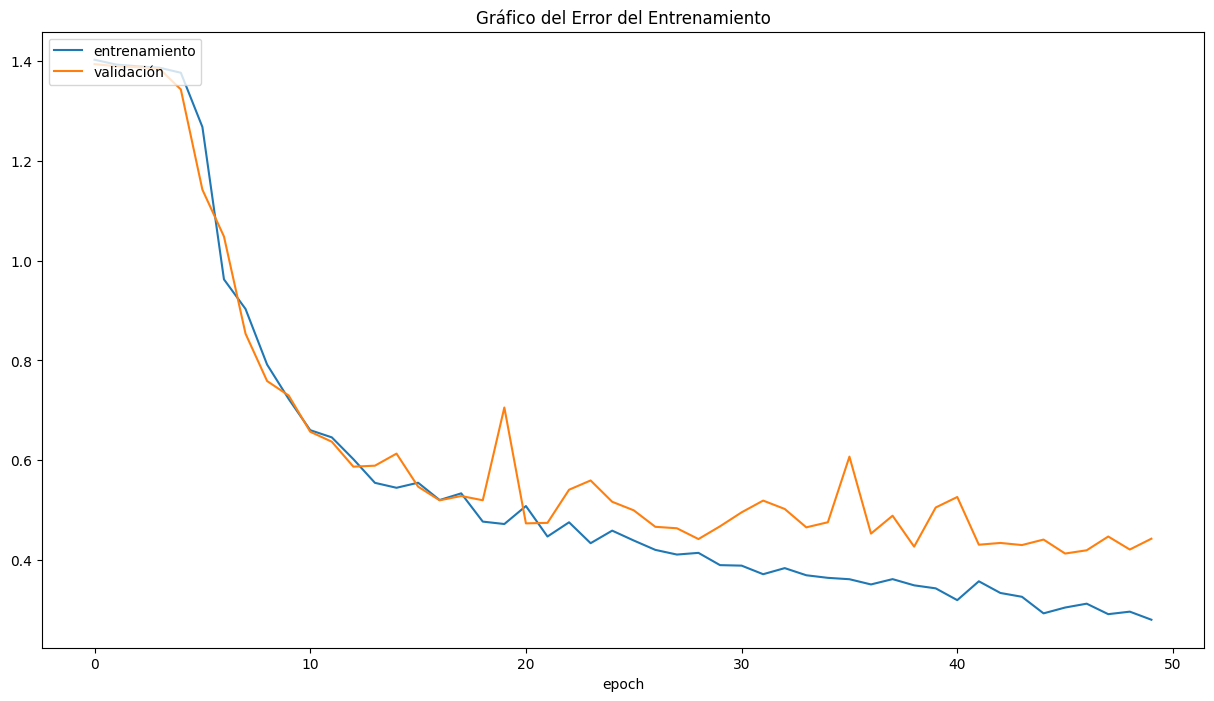

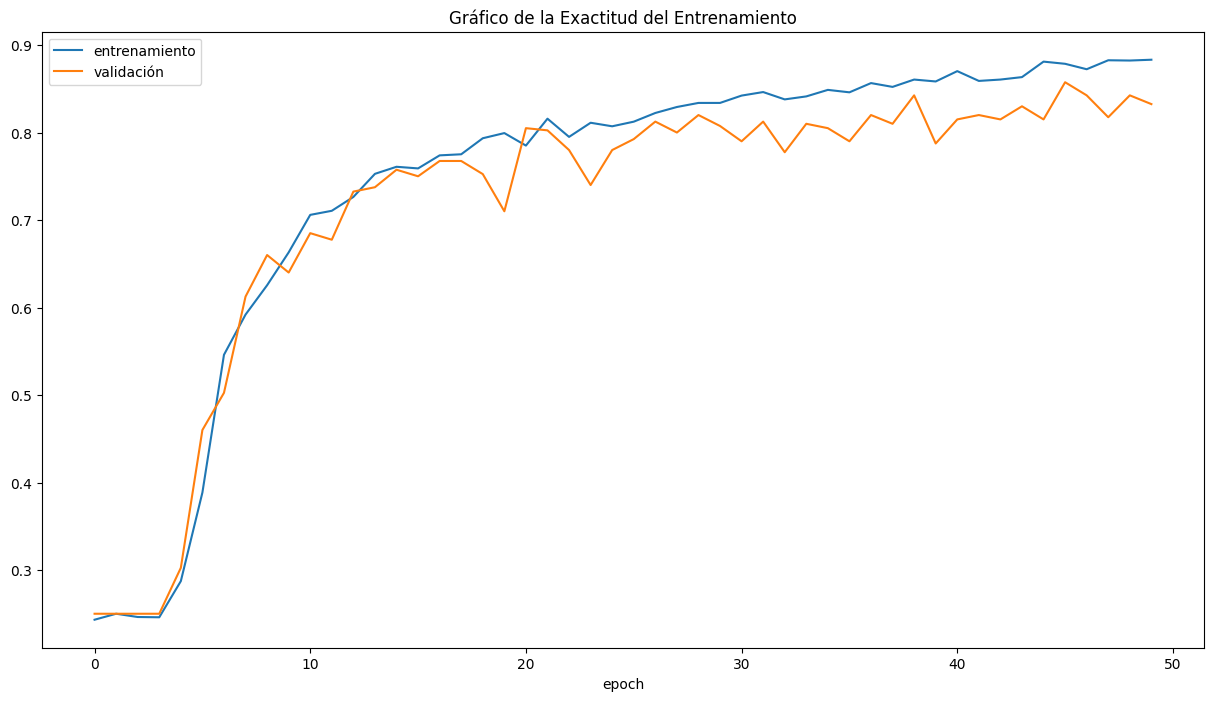

In [ ]:
# Restaurar mejores pesos (si corresponde)
early_stopper.restore(model)
print("✅ Modelo restaurado al mejor estado según validación.")

# Guardar
torch.save(model.state_dict(), "modelo_cnn.pth")

plt.figure(figsize=(15,8))
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

plt.figure(figsize=(15,8))
plt.plot(train_accs)
plt.plot(val_accs)
plt.title('Gráfico de la Exactitud del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

In [ ]:
precision_final = correctas / total_muestras
print(f"\n--- Resultados de la Evaluación Final de la CNN ---")
print(f"Total de imágenes evaluadas: {total_muestras}")
print(f"Imágenes clasificadas correctamente: {correctas}")
print(f"Precisión FINAL del modelo CNN en todas las imágenes válidas: {precision_final:.4f}")


--- Resultados de la Evaluación Final de la CNN ---
Total de imágenes evaluadas: 4217
Imágenes clasificadas correctamente: 3694
Precisión FINAL del modelo CNN en todas las imágenes válidas: 0.8760


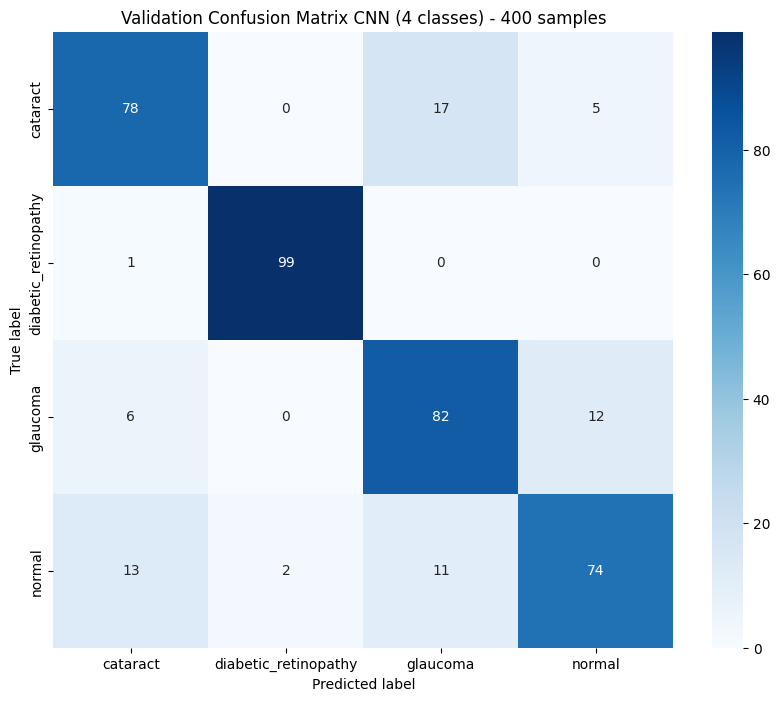

Validation Accuracy: 0.833
Validation samples: 400

Detailed Classification Report (Validation Data):
                      precision    recall  f1-score   support

            cataract      0.796     0.780     0.788       100
diabetic_retinopathy      0.980     0.990     0.985       100
            glaucoma      0.745     0.820     0.781       100
              normal      0.813     0.740     0.775       100

            accuracy                          0.833       400
           macro avg      0.834     0.833     0.832       400
        weighted avg      0.834     0.833     0.832       400

Comparison:
Validation accuracy: 0.833
Full dataset accuracy (4,217 samples): 0.876
Difference: -0.043


In [ ]:
# Create confusion matrix using the SAME 400 validation samples as ROC curves
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert probabilities to hard predictions (same as ROC curves use)
val_hard_predictions = np.argmax(val_pred_probabilities, axis=1)

# Create confusion matrix with same data as ROC
val_cm = confusion_matrix(val_true_labels, val_hard_predictions,
                          labels=list(range(len(class_names))))

# Plot the validation confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title(f'Validation Confusion Matrix CNN ({len(class_names)} classes) - 400 samples')
plt.savefig("MatrizConfusion_Validacion_CNN.png")
plt.show()

# Calculate validation metrics
val_accuracy = accuracy_score(val_true_labels, val_hard_predictions)
print(f"Validation Accuracy: {val_accuracy:.3f}")
print(f"Validation samples: {len(val_true_labels)}")

# Detailed classification report
print("\nDetailed Classification Report (Validation Data):")
print(classification_report(val_true_labels, val_hard_predictions,
                          target_names=class_names, digits=3))

# Compare with your full dataset accuracy
full_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"Comparison:")
print(f"Validation accuracy: {val_accuracy:.3f}")
print(f"Full dataset accuracy: {full_accuracy:.3f}")
print(f"Difference: {val_accuracy - full_accuracy:.3f}")

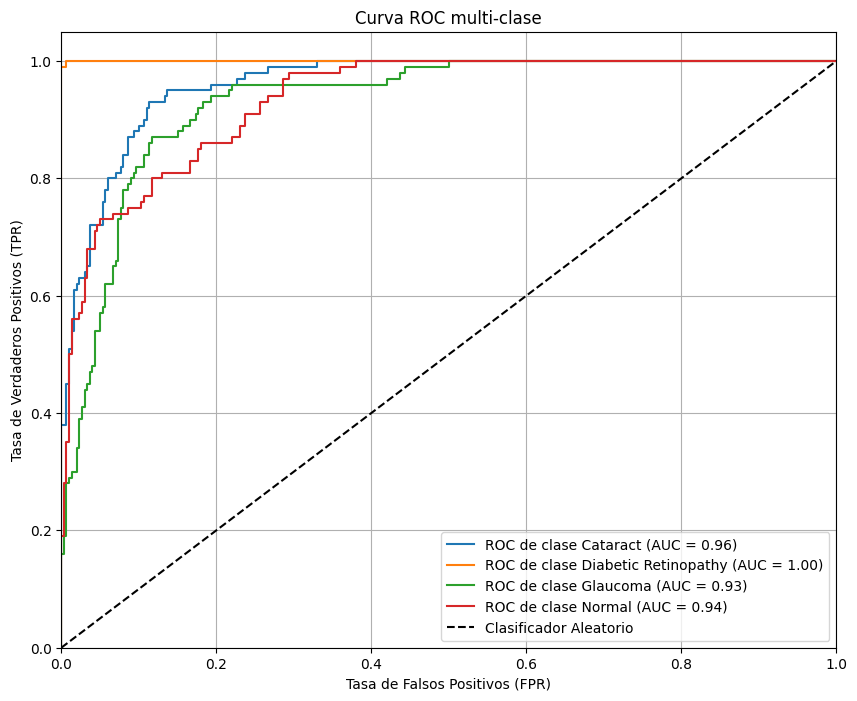

In [ ]:
# Calcular la curva ROC y el AUC para cada clase
plt.figure(figsize=(10, 8))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(np.array(val_true_labels) == i, np.array(val_pred_probabilities)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar la curva ROC para cada clase
for i in range(len(class_names)):
    label_name = class_names[i].replace("_", " ").title()
    plt.plot(fpr[i], tpr[i], label=f'ROC de clase {label_name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC multi-clase')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("CurvaROC_CNN.png")
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

# Convert to numpy arrays
y_true = np.array(val_true_labels)
y_score = np.array(val_pred_probabilities)

# Compute macro-average ROC AUC (one-vs-rest)
roc_auc_macro = roc_auc_score(y_true, y_score, multi_class='ovr', average='macro')
roc_auc_weighted = roc_auc_score(y_true, y_score, multi_class='ovr', average='weighted')

print(f"ROC AUC Macro-average: {roc_auc_macro:.3f}")
print(f"ROC AUC Weighted-average: {roc_auc_weighted:.3f}")

ROC AUC Macro-average: 0.957
ROC AUC Weighted-average: 0.957
